<h1>
Behavior classification starter kit 🐁🐀
</h1>
This code is adapted from a notebook created by Dipam Chakraborty at AIcrowd for the <a href=https://www.aicrowd.com/challenges/multi-agent-behavior-representation-modeling-measurement-and-applications>Multi-Agent Behavior Challenge</a>.


# Import necessary modules and packages 📚


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Download the dataset 📲

The CalMS21 dataset is hosted by [Caltech](https://data.caltech.edu/records/1991). For now, we'll focus on the Task 1 data, which can be downloaded as follows:

In [ ]:
# @title Download and unzip the data
import os, requests, zipfile

fname = 'task1_classic_classification.zip'
url = "https://data.caltech.edu/records/s0vdx-0k302/files/task1_classic_classification.zip?download=1"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)
else:
  print('Data have already been downloaded!!!')

if not os.path.exists('task1_classic_classification'):
  # Unzip the file
  with zipfile.ZipFile(fname, 'r') as zip_ref:
    zip_ref.extractall('.')


# Download the script
fname = 'calms21_convert_to_npy.py'
url = "https://data.caltech.edu/records/s0vdx-0k302/files/calms21_convert_to_npy.py?download=1"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

The dataset files are stored as json files. For ease of handling, we'll first convert them to .npy files using the script we just downloaded, `calms21_convert_to_npy.py`. The output of this script is a pair of files, `calms21_task1_train.npy` and `calms21_task1_test.npy`.

If you include the optional `parse_treba` flag, the script will create files `calms21_task1_train_features.npy` and `calms21_task1_test_features.npy`, which contain 32 features created using <a href=https://openaccess.thecvf.com/content/CVPR2021/html/Sun_Task_Programming_Learning_Data_Efficient_Behavior_Representations_CVPR_2021_paper.html>Task Programming</a>.



In [ ]:
!python calms21_convert_to_npy.py  --input_directory '.' --output_directory '.'

Saving ./calms21_task1_test
Saving ./calms21_task1_train


#Load the data 💾
The following loader function can be used to unpack the `.npy` files containing your train and test sets.

In [ ]:
def load_task1_data(data_path):
  """
  Load data for task 1:
      The vocaubulary tells you how to map behavior names to class ids;
      it is the same for all sequences in this dataset.
  """
  data_dict = np.load(data_path, allow_pickle=True).item()
  dataset = data_dict['annotator-id_0']
  # Get any sequence key.
  sequence_id = list(data_dict['annotator-id_0'].keys())[0]
  vocabulary = data_dict['annotator-id_0'][sequence_id]['metadata']['vocab']
  return dataset, vocabulary

In [ ]:
training_data, vocab = load_task1_data('./calms21_task1_train.npy')
test_data, _ = load_task1_data('./calms21_task1_test.npy')

In [ ]:
# training_data, vocab = load_task1_data('/content/drive/MyDrive/CalM21_npy/calms21_task1_train.npy')
# test_data, _ = load_task1_data('/content/drive/MyDrive/CalM21_npy/calms21_task1_test.npy')

## Dataset Specifications

`training_data` and `test_data` are both dictionaries with a key for each Sequence in the dataset, where a Sequence is a single resident-intruder assay. Each Sequence contains the following fields:

<ul>
<li><b>keypoints</b>: tracked locations of body parts on the two interacting mice. These are produced using a Stacked Hourglass network trained on 15,000 hand-labeled frames.
<ul>
<li>Dimensions: (# frames) x (mouse ID) x (x, y coordinate) x (body part).
<li>Units: pixels; coordinates are relative to the entire image. Original image dimensions are 1024 x 570.
</ul>
<li><b>scores</b>: confidence estimates for the tracked keypoints.
<ul>
<li>Dimensions: (# frames) x (mouse ID) x (body part).
<li>Units: unitless, range 0 (lowest confidence) to 1 (highest confidence).
</ul>
<li> <b>annotations</b>: behaviors id as an integer annotated at each frame by a domain expert. See below for the behavior id to behavior name mappings.
<ul>
<li>Dimensions: (# frames) .
</ul>
<li><b>metadata</b>: The recorded metadata is annotator_id which is represented by an int, and the vocab, containing a dictionary which maps behavior names to integer ids in annotations.
</ul>

The 'taskprog_features' file contains the additional field:

<ul>
<li><b>features</b>: pre-computed features from a model trained with task programming on the trajectory data of the CalMS21 unlabeled videos set.
<ul>
<li>Dimensions: (# frames) x (feature dim = 32).
</li>
</ul>
</ul>

<b>NOTE:</b> for all keypoints, mouse 0 is the resident (black) mouse and mouse 1 is the intruder (white) mouse. There are 7 tracked body parts, ordered (nose, left ear, right ear, neck, left hip, right hip, tail base).

## What does the data look like? 🔍

### Data overview

As described above, our dataset consists of train and test sets, which are both dictionaries of Sequences, and an accompanying vocabulary telling us which behavior is which:

In [ ]:
print("Sample dataset keys: ", list(training_data.keys())[:3])
print("Vocabulary: ", vocab)
print("Number of train Sequences: ", len(training_data))
print("Number of test Sequences: ", len(test_data))

Sample dataset keys:  ['task1/train/mouse001_task1_annotator1', 'task1/train/mouse002_task1_annotator1', 'task1/train/mouse003_task1_annotator1']
Vocabulary:  {'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
Number of train Sequences:  70
Number of test Sequences:  19


### Sample overview
Next let's take a look at one example Sequence: <br>
(where a Sequence is a single resident-intruder assay.) <br>(nose, left ear, right ear, neck, left hip, right hip, tail base)

In [ ]:
sequence_names = list(training_data.keys())
sample_sequence_key = sequence_names[35]
single_sequence = training_data[sample_sequence_key]
# print(sequence_names) task1/train/mouse0xx_task1_annotator1
#print(single_sequence)
print("Name of our sample sequence: ", sample_sequence_key)
print("Sequence keys: ", single_sequence.keys())
print("Sequence metadata: ", single_sequence['metadata'])
print(f"Number of Frames in Sequence \"{sample_sequence_key}\": ", len(single_sequence['annotations']))
print(f"Keypoints data shape of Sequence \"{sample_sequence_key}\": ", single_sequence['keypoints'].shape)

Name of our sample sequence:  task1/train/mouse036_task1_annotator1
Sequence keys:  dict_keys(['keypoints', 'scores', 'annotations', 'metadata'])
Sequence metadata:  {'annotator-id': 0, 'vocab': {'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}}
Number of Frames in Sequence "task1/train/mouse036_task1_annotator1":  96
Keypoints data shape of Sequence "task1/train/mouse036_task1_annotator1":  (96, 2, 2, 7)


Dimensions: (# frames) x (mouse ID) x (x, y coordinate) x (body part).
Units: pixels; coordinates are relative to the entire image. Original image dimensions are 1024 x 570

<function matplotlib.pyplot.show(close=None, block=None)>

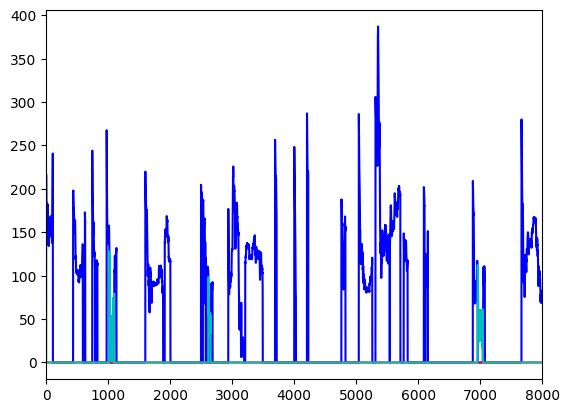

In [ ]:
##SOODEH:
sequence_names = list(training_data.keys())

invest_dist =np.zeros(30000)
attack_dist =np.zeros(30000)
mount_dist  =np.zeros(30000)
velocity1   =np.zeros(6000)
count = 0

# for j in range(len(sequence_names)):
for j in [9]:
  sample_sequence_key = sequence_names[j]
  single_sequence = training_data[sample_sequence_key]
  keypoint_sequence = single_sequence['keypoints']
  annotation_sequence = single_sequence['annotations']
  seq = keypoint_sequence.transpose((0,1,3,2))

  t = len(annotation_sequence)
  t = keypoint_sequence.shape[0]
  for i in range(t):
    xy1 = seq[i, 0, :, :]
    xy2 = seq[i, 1, :, :]
    xy1_center = np.mean(xy1,axis=0)
    xy2_center = np.mean(xy2,axis=0)

    distance = np.sqrt(((xy1_center[0]-xy2_center[0])**2)+((xy1_center[1]-xy2_center[1])**2))

    if not(np.isnan(distance)):
      if(annotation_sequence[i]==0): #attack
        attack_dist[i] += distance
      elif(annotation_sequence[i]==1): #investigate
        invest_dist[i] += distance
      elif(annotation_sequence[i]==2): #mount
        mount_dist[i] += distance

plt.xlim([0, 8000])
plt.plot(invest_dist, color='b')
plt.plot(attack_dist, color='r')
plt.plot(mount_dist, color='c')
plt.show

In [ ]:
single_sequence['keypoints'].shape

(8666, 2, 2, 7)

In [ ]:
single_sequence.keys()

dict_keys(['keypoints', 'scores', 'annotations', 'metadata'])

In [ ]:
single_sequence['annotations'].shape

(8666,)

In [ ]:
body_parts = ["nose", "left_ear", "right_ear", "neck", "left_hip", "right_hip", "tail_base"]
# Create an empty list to collect the coordinate pairs
data = []

In [ ]:
# for seq_name in sequence_names:
#   curr_sequence = training_data[seq_name]
#   curr_keypoints = curr_sequence['keypoints']
#   for frame_num in range(len(curr_keypoints)):
#     for mouse_id in range(2):
#       for i, body_part in enumerate(body_parts):
#         x = curr_keypoints[:, mouse_id, 0, i]
#         y = curr_keypoints[:, mouse_id, 1, i]
#         for j in range(len(x)):
#           data.append((frame_num, mouse_id, body_part, x[j], y[j]))

# # Convert the list to a DataFrame
# df = pd.DataFrame(data, columns=['Frame Number', 'Mouse ID', 'Body Part', 'X', 'Y'])

# print(df)

In [1]:
#single_keypoints[:, mouse_id, 0, :].shape

In [ ]:
np.mean(single_keypoints[:, mouse_id, 0, :], axis=1).shape

# Ploting the average (x, y) of body parts

In [ ]:
vocab

{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}

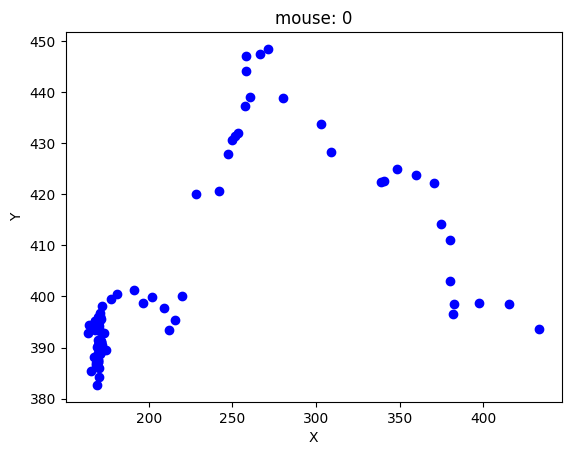

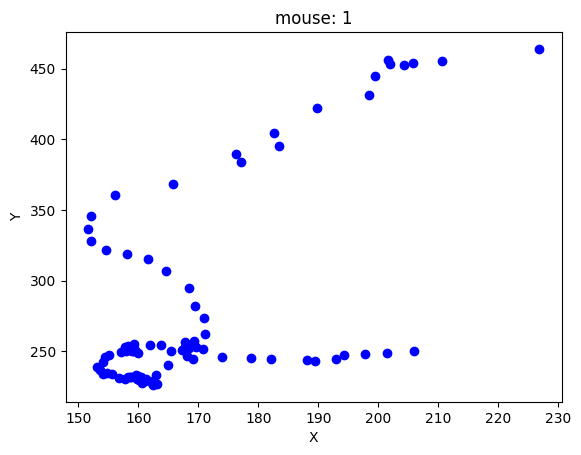

In [ ]:
single_keypoints = single_sequence['keypoints']
single_annotations = single_sequence['annotations']
for mouse_id in range(2):
      x = np.mean(single_keypoints[:, mouse_id, 0, :], axis=1)
      y = np.mean(single_keypoints[:, mouse_id, 1, :], axis=1)
      # Plot the movement
      for i in range(96):
        if single_annotations[i] == 0:
            plt.plot(x[i], y[i], marker='o', color='red')
        else:
            plt.plot(x[i], y[i], marker='o', color='blue')

      # Set axis labels and title
      plt.xlabel('X')
      plt.ylabel('Y')
      plt.title(f'mouse: {mouse_id}')

      # Show the plot
      plt.show()

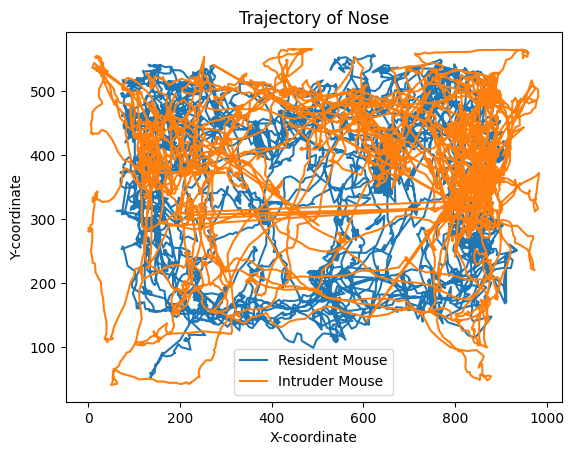

In [ ]:
# Select the body part index for the nose
nose_index = 0

# Extract the (x, y) coordinates of the nose for each mouse
resident_nose_coords = single_keypoints[:, 0, :, nose_index]
intruder_nose_coords = single_keypoints[:, 1, :, nose_index]

# Plot the trajectory of the nose for both mice
plt.plot(resident_nose_coords[:, 0], resident_nose_coords[:, 1], label='Resident Mouse')
plt.plot(intruder_nose_coords[:, 0], intruder_nose_coords[:, 1], label='Intruder Mouse')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Trajectory of Nose')
plt.legend()
plt.show()

In [ ]:
single_keypoints.shape

(8666, 2, 2, 7)

In [ ]:
# Get the body part indices for the relevant body parts (e.g., neck, left hip, right hip)
neck_index = 3
left_hip_index = 4
right_hip_index = 5

# Initialize an empty list to store the distances
distances = np.zeros(single_keypoints.shape[0])

# Iterate through the frames
for frame in range(single_keypoints.shape[0]):
    # Calculate the centroid coordinates for each mouse
    resident_centroid = np.mean(single_keypoints[frame, 0, :, [neck_index, left_hip_index, right_hip_index]], axis=0)
    intruder_centroid = np.mean(single_keypoints[frame, 1, :, [neck_index, left_hip_index, right_hip_index]], axis=0)

    # Calculate the Euclidean distance between the centroids
    distance = np.linalg.norm(resident_centroid - intruder_centroid)
    distances[frame] = distance

# Print the distances and velocities
print("Distances:", distances.mean())


Distances: 305.92615202464066


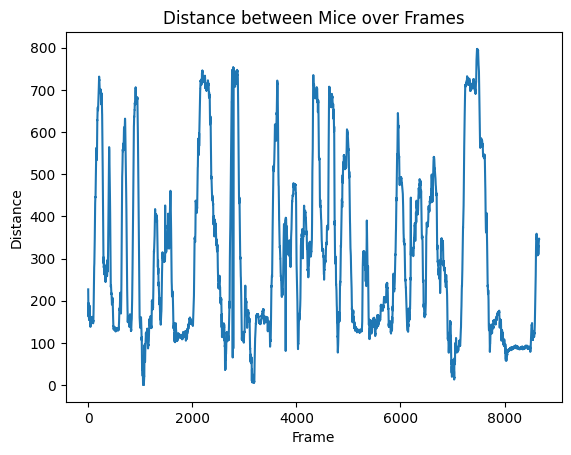

In [ ]:
# Create the plot
plt.plot(range(len(distances)), distances)
plt.xlabel('Frame')
plt.ylabel('Distance')
plt.title('Distance between Mice over Frames')
plt.show()

In [ ]:
vocab


{'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}

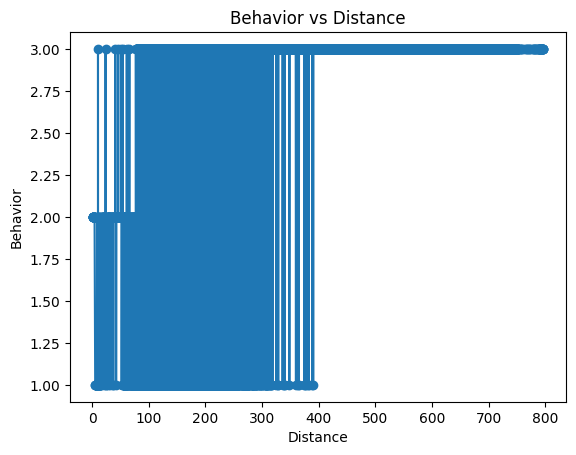

In [ ]:
# Get unique distances and corresponding behavior labels
unique_distances = np.unique(distances)
behavior_labels = []

# Calculate the average behavior label for each unique distance
for dist in unique_distances:
    indices = np.where(distances == dist)
    avg_label = np.mean(single_annotations[indices])
    behavior_labels.append(avg_label)

# Create a line plot of behavior labels over distances
plt.plot(unique_distances, behavior_labels, marker='o')
plt.xlabel('Distance')
plt.ylabel('Behavior')
plt.title('Behavior vs Distance')
plt.show()


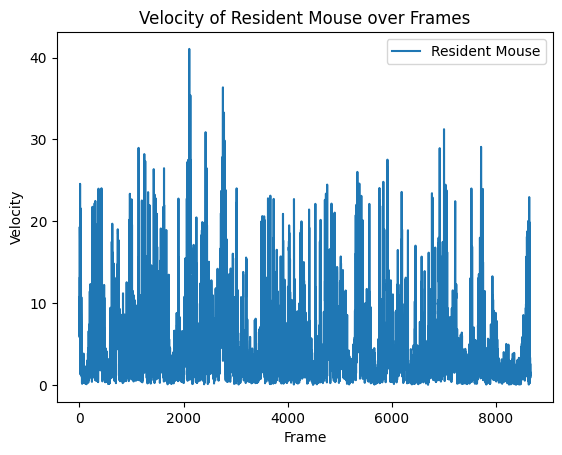

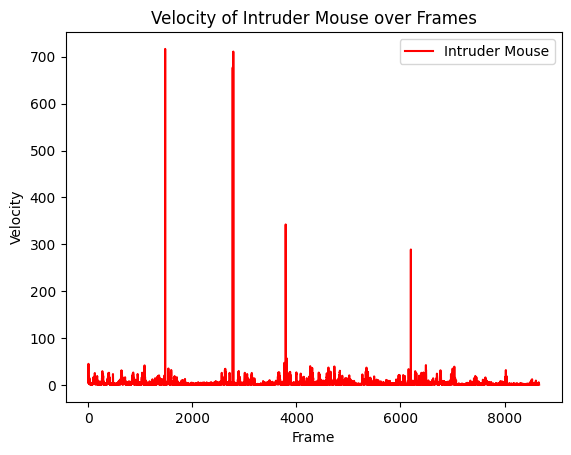

In [ ]:
# Initialize empty NumPy arrays to store the velocities of each mouse
resident_velocities = np.zeros(single_keypoints.shape[0] - 1)
intruder_velocities = np.zeros(single_keypoints.shape[0] - 1)

# Iterate through the frames
for frame in range(1, single_keypoints.shape[0]):
    # Calculate the centroid coordinates for each mouse in the current and previous frames
    resident_centroid_current = np.mean(single_keypoints[frame, 0, :, [neck_index, left_hip_index, right_hip_index]], axis=0)
    intruder_centroid_current = np.mean(single_keypoints[frame, 1, :, [neck_index, left_hip_index, right_hip_index]], axis=0)

    resident_centroid_previous = np.mean(single_keypoints[frame-1, 0, :, [neck_index, left_hip_index, right_hip_index]], axis=0)
    intruder_centroid_previous = np.mean(single_keypoints[frame-1, 1, :, [neck_index, left_hip_index, right_hip_index]], axis=0)

    # Calculate the Euclidean distance between the mouse positions in consecutive frames
    distance_resident = np.linalg.norm(resident_centroid_current - resident_centroid_previous)
    distance_intruder = np.linalg.norm(intruder_centroid_current - intruder_centroid_previous)

    # Calculate the velocity (assuming a fixed time difference)
    time_difference = 1.0  # Assuming a time difference of 1 frame (adjust as per your data)
    velocity_resident = distance_resident / time_difference
    velocity_intruder = distance_intruder / time_difference

    # Store the velocity in the respective arrays
    resident_velocities[frame-1] = velocity_resident
    intruder_velocities[frame-1] = velocity_intruder

# Create the plot for resident mouse velocity
plt.plot(range(len(resident_velocities)), resident_velocities, label='Resident Mouse')
plt.xlabel('Frame')
plt.ylabel('Velocity')
plt.title('Velocity of Resident Mouse over Frames')
plt.legend()
plt.show()

# Create the plot for intruder mouse velocity
plt.plot(range(len(intruder_velocities)), intruder_velocities, label='Intruder Mouse', color='red')
plt.xlabel('Frame')
plt.ylabel('Velocity')
plt.title('Velocity of Intruder Mouse over Frames')
plt.legend()
plt.show()


# Helper functions for visualization 💁


This cell contains some helper functions that we'll use to create an animation of the mouse movements. You can ignore the contents, but be sure to run it or the next section won't work.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib import rc
import matplotlib.patches as mpatches

rc('animation', html='jshtml')

# Note: Image processing may be slow if too many frames are animated.

# Plotting constants
FRAME_WIDTH_TOP = 1024
FRAME_HEIGHT_TOP = 570

RESIDENT_COLOR = 'lawngreen'
INTRUDER_COLOR = 'skyblue'

PLOT_MOUSE_START_END = [(0, 1), (0, 2), (1, 3), (2, 3), (3, 4),
                        (3, 5), (4, 6), (5, 6), (1, 2)]
class_to_color = {'other': 'white', 'attack' : 'red', 'mount' : 'green',
                  'investigation': 'orange'}
class_to_number = {s: i for i, s in enumerate(vocab)}
number_to_class = {i: s for i, s in enumerate(vocab)}


def num_to_text(anno_list):
  return np.vectorize(number_to_class.get)(anno_list)


def set_figax():
  fig = plt.figure(figsize=(6, 4))

  img = np.zeros((FRAME_HEIGHT_TOP, FRAME_WIDTH_TOP, 3))

  ax = fig.add_subplot(111)
  ax.imshow(img)

  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  return fig, ax


def plot_mouse(ax, pose, color):
  # Draw each keypoint
  for j in range(7):
    ax.plot(pose[j, 0], pose[j, 1], 'o', color=color, markersize=5)

  # Draw a line for each point pair to form the shape of the mouse

  for pair in PLOT_MOUSE_START_END:
    line_to_plot = pose[pair, :]
    ax.plot(line_to_plot[:, 0], line_to_plot[
            :, 1], color=color, linewidth=1)


def animate_pose_sequence(video_name, keypoint_sequence, start_frame = 0, stop_frame = 100,
                          annotation_sequence = None):
  # Returns the animation of the keypoint sequence between start frame
  # and stop frame. Optionally can display annotations.
  seq = keypoint_sequence.transpose((0,1,3,2))

  image_list = []

  counter = 0
  for j in range(start_frame, stop_frame):
    if counter%20 == 0:
      print("Processing frame ", j)
    fig, ax = set_figax()
    plot_mouse(ax, seq[j, 0, :, :], color=RESIDENT_COLOR)
    plot_mouse(ax, seq[j, 1, :, :], color=INTRUDER_COLOR)

    if annotation_sequence is not None:
      annot = annotation_sequence[j]
      annot = number_to_class[annot]
      plt.text(50, -20, annot, fontsize=16,
               bbox=dict(facecolor=class_to_color[annot], alpha=0.5))

    ax.set_title(
        video_name + '\n frame {:03d}.png'.format(j))

    ax.axis('off')
    fig.tight_layout(pad=0)
    ax.margins(0)

    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(),
                                    dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(
        fig.canvas.get_width_height()[::-1] + (3,))

    image_list.append(image_from_plot)

    plt.close()
    counter = counter + 1

  # Plot animation.
  fig = plt.figure()
  plt.axis('off')
  im = plt.imshow(image_list[0])

  def animate(k):
      im.set_array(image_list[k])
      return im,
  ani = animation.FuncAnimation(fig, animate, frames=len(image_list), blit=True)
  return ani


def plot_behavior_raster(annotation_sequence, start_frame=0,
                         stop_frame=100,
                         title="Behavior Labels"):
  # Plot annotations as a behavior raster

  # Map annotations to a number.
  annotation_num = []
  for item in annotation_sequence[start_frame:stop_frame]:
    annotation_num.append(class_to_number[item])

  all_classes = list(set(annotation_sequence[start_frame:stop_frame]))

  cmap = colors.ListedColormap(['red', 'orange', 'green', 'white'])
  bounds=[-0.5, 0.5, 1.5, 2.5, 3.5]
  norm = colors.BoundaryNorm(bounds, cmap.N)

  height = 200
  arr_to_plot = np.repeat(np.array(annotation_num)[:, np.newaxis].transpose(),
                                                  height, axis = 0)

  fig, ax = plt.subplots(figsize = (16, 3))
  ax.imshow(arr_to_plot, interpolation='none',cmap=cmap, norm=norm)

  ax.set_yticks([])
  ax.set_xlabel('Frame Number')
  plt.title(title)

  legend_patches = []
  for item in all_classes:
    legend_patches.append(mpatches.Patch(color=class_to_color[item], label=item))

  plt.legend(handles=legend_patches,loc='center left', bbox_to_anchor=(1, 0.5))

  plt.tight_layout()

# Visualize the animals' movements 🎥

Let's make some gifs of our sample sequence to get a sense of what the raw data looks like! You can change the values of `start_frame` and `stop_frame` to look around.

Processing frame  0
Processing frame  20
Processing frame  40
Processing frame  60
Processing frame  80


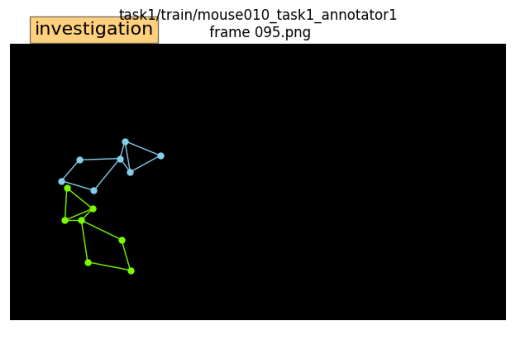

In [ ]:
keypoint_sequence = single_sequence['keypoints']
annotation_sequence = single_sequence['annotations']

ani = animate_pose_sequence(sample_sequence_key,
                            keypoint_sequence,
                            start_frame=0,
                            stop_frame=96,
                            annotation_sequence=annotation_sequence)

# Display the animaion on colab
ani

### We can also look at a **behavior raster**, which shows what behavior was annotated on each frame of this video.

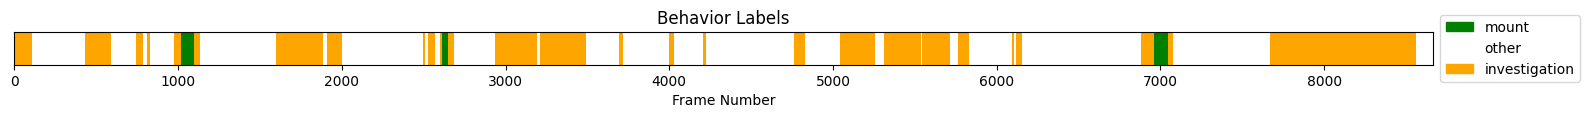

In [ ]:
annotation_sequence = single_sequence['annotations']
text_sequence = num_to_text(annotation_sequence)

plot_behavior_raster(
    text_sequence,
    start_frame=0,
    stop_frame=len(annotation_sequence)
    )

In [ ]:
#  vocab': {'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}

In [ ]:
attack_frames = []
for i, label in enumerate(annotation_sequence):
  if label == 0:
    attack_frames.append(i)
print(attack_frames)

[]


# Basic exploratory data analysis 🤓
Each Sequence has different amounts of each behavior, depending on what the mice do during the assay. Here, we get the percentage of frames of each behavior in each sequence. We can use this to split the training set into train and validation sets in a stratified way.

In [ ]:
def get_percentage(sequence_key):
  anno_seq = num_to_text(training_data[sequence_key]['annotations'])
  counts = {k: np.mean(np.array(anno_seq) == k)*100.0 for k in vocab}
  return counts


anno_percentages = {k: get_percentage(k) for k in training_data}
anno_perc_df = pd.DataFrame(anno_percentages).T
print("Percentage of frames in every sequence for every class")
anno_perc_df.head()

Percentage of frames in every sequence for every class


attack  investigation      mount  \
task1/train/mouse001_task1_annotator1  0.000000      15.788242  30.251826   
task1/train/mouse002_task1_annotator1  9.067880      22.757587   0.000000   
task1/train/mouse003_task1_annotator1  0.000000      13.757374  13.167448   
task1/train/mouse004_task1_annotator1  0.000000      16.440199   7.735773   
task1/train/mouse005_task1_annotator1  7.516398      13.614607   0.000000   

                                           other  
task1/train/mouse001_task1_annotator1  53.959933  
task1/train/mouse002_task1_annotator1  68.174533  
task1/train/mouse003_task1_annotator1  73.075178  
task1/train/mouse004_task1_annotator1  75.824028  
task1/train/mouse005_task1_annotator1  78.868995

## Percent of frames of each behavior in the full training set
Having looked at behavior distributions in a couple example Sequences, let's now look at the average over the entire training set.

In [ ]:
all_annotations = []
for sk in training_data:
  anno = training_data[sk]['annotations']
  all_annotations.extend(list(anno))

all_annotations = num_to_text(all_annotations)
classes, counts = np.unique(all_annotations, return_counts=True)
pd.DataFrame({"Behavior": classes,
              "Percentage Frames": counts/len(all_annotations)*100.0})

Behavior  Percentage Frames
0         attack           2.765009
1  investigation          28.876113
2          mount           5.635781
3          other          62.723097

In [ ]:
print (len(all_annotations))

507738


# Split training data into train/validation sets
Because we don't want to overfit to our test set, we'll create a new validation set to test on while we're experimenting with our model.

We'll use the first cell to create some helper functions, and then implement the split in the following cell.

In [ ]:
from sklearn.model_selection import train_test_split


def num_to_text(number_to_class, anno_list):
  """
  Convert list of class numbers to list of class names
  """
  return np.vectorize(number_to_class.get)(anno_list)


def split_validation(orig_pose_dictionary, vocabulary, seed=2021,
               test_size=0.5, split_videos=False):
  """
  Split data into train and validation sets:
  * Full sequences are either put into train or validation to avoid data leakage
  * By default, the "attack" behavior's presence is used to stratify the split
  * Optionally, the sequences may be split into half and treated as separate sequences
  """

  if test_size == 0.0:
    return orig_pose_dictionary, None

  number_to_class = {v: k for k, v in vocabulary.items()}
  if split_videos:
    pose_dictionary = {}
    for key in orig_pose_dictionary:
      key_pt1 = key + '_part1'
      key_pt2 = key + '_part2'
      anno_len = len(orig_pose_dictionary[key]['annotations'])
      split_idx = anno_len // 2
      pose_dictionary[key_pt1] = {
          'annotations': orig_pose_dictionary[key]['annotations'][:split_idx],
          'keypoints': orig_pose_dictionary[key]['keypoints'][:split_idx]}
      pose_dictionary[key_pt2] = {
          'annotations': orig_pose_dictionary[key]['annotations'][split_idx:],
          'keypoints': orig_pose_dictionary[key]['keypoints'][split_idx:]}
  else:
    pose_dictionary = orig_pose_dictionary

  def get_percentage(sequence_key):
    anno_seq = num_to_text(
        number_to_class, pose_dictionary[sequence_key]['annotations'])
    counts = {k: np.mean(np.array(anno_seq) == k) for k in vocabulary}
    return counts

  anno_percentages = {k: get_percentage(k) for k in pose_dictionary}

  anno_perc_df = pd.DataFrame(anno_percentages).T

  rng_state = np.random.RandomState(seed)
  try:
    idx_train, idx_val = train_test_split(anno_perc_df.index,
                                          stratify=anno_perc_df['attack'] > 0,
                                          test_size=test_size,
                                          random_state=rng_state)
  except:
    idx_train, idx_val = train_test_split(anno_perc_df.index,
                                          test_size=test_size,
                                          random_state=rng_state)

  train_data = {k: pose_dictionary[k] for k in idx_train}
  val_data = {k: pose_dictionary[k] for k in idx_val}
  return train_data, val_data

In [ ]:
train, val = split_validation(training_data, vocab, test_size=0.25)
print("Number of Sequences in train set: ", len(train))
print("Number of Sequences in validation set: ", len(val))

Number of Sequences in train set:  52
Number of Sequences in validation set:  18


# Preprocessing script

We might also want to normalize the data, based on the information that the frame size is 1024x570

The original data is of shape (sequence length, mouse, x y coordinate, keypoint)
 = (length, 2, 2, 7)

If `rotate==True`, this code also swaps the x y and the keypoint axis, to make rotation of the poses (eg to center on one of the mice) easier.

In [ ]:
def normalize_data(orig_pose_dictionary, rotate=False):
  for key in orig_pose_dictionary:
    X = orig_pose_dictionary[key]['keypoints']
    if rotate:
      X = X.transpose((0, 1, 3, 2))  # last axis is x, y coordinates
      X[..., 0] = X[..., 0]/1024
      X[..., 1] = X[..., 1]/570
    else:
      X[:, :, 0, :] = X[:, :, 0, :] / 1024
      X[: ,:, 1, :] = X[:, :, 1, :] / 570
    orig_pose_dictionary[key]['keypoints'] = X
  return orig_pose_dictionary

In [1]:
#df = pd.DataFrame.from_dict(training_data, orient='annotations')
#print(df)

# Clastering and SVM

## !! CODE BELOW IS GENERATED BY GPT4 ACCORDING TO THE PAPER ["Unbiased analysis of mouse social behaviour using unsupervised machine learning"](https://ieeexplore.ieee.org/document/7950656) AS A FORM OF QUICK CHECK - IT DEFFINITLY NEEDS A LOT OF ADJUSTING (and diffrent methods maybe) TO MEET CRITERIA OF USED METHODS !!

Warning: Code below takes about 5 min to proceed

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import FastICA
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold

def prepare_data(data_dict):
    data = []
    for session in data_dict.values():
        session_data = session['keypoints']
        # Reshape the session_data into a 2D array and append it to the data list
        reshaped_data = session_data.reshape(session_data.shape[0], -1)
        data.append(reshaped_data)
    # Concatenate all data along the first axis (i.e., stack the 2D arrays vertically)
    return np.concatenate(data, axis=0)

# Prepare your data
prepared_train_data = prepare_data(train)

# Now you can use prepared_train_data in FastICA and GaussianMixture

# Perform ICA to extract independent components
ica = FastICA(n_components=7, random_state=0, whiten='unit-variance')
ics = ica.fit_transform(prepared_train_data)

# Perform GMM based clustering
gmm = GaussianMixture(n_components=7, random_state=0)
gmm.fit(ics)
labels = gmm.predict(ics)

# Cross-validation with 10 subsamplings
kf = KFold(n_splits=10)

for train_index, test_index in kf.split(prepared_train_data):
    # Perform ICA and GMM on training set
    ica = FastICA(n_components=7, random_state=0)
    gmm = GaussianMixture(n_components=7, random_state=0)

    ics_train = ica.fit_transform(prepared_train_data[train_index])
    gmm.fit(ics_train)

    # Apply the ICA transformation and GMM prediction on test set
    ics_test = ica.transform(prepared_train_data[test_index])
    labels_test = gmm.predict(ics_test)

# At this point, you would typically calculate some performance metric to assess the validity of your model.



/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whi

In [ ]:
def prepare_data(data_dict):
    data = []
    for session in data_dict.values():
        session_data = session['keypoints']
        # Reshape the session_data into a 2D array and append it to the data list
        reshaped_data = session_data.reshape(session_data.shape[0], -1)
        data.append(reshaped_data)
    # Concatenate all data along the first axis (i.e., stack the 2D arrays vertically)
    return np.concatenate(data, axis=0)


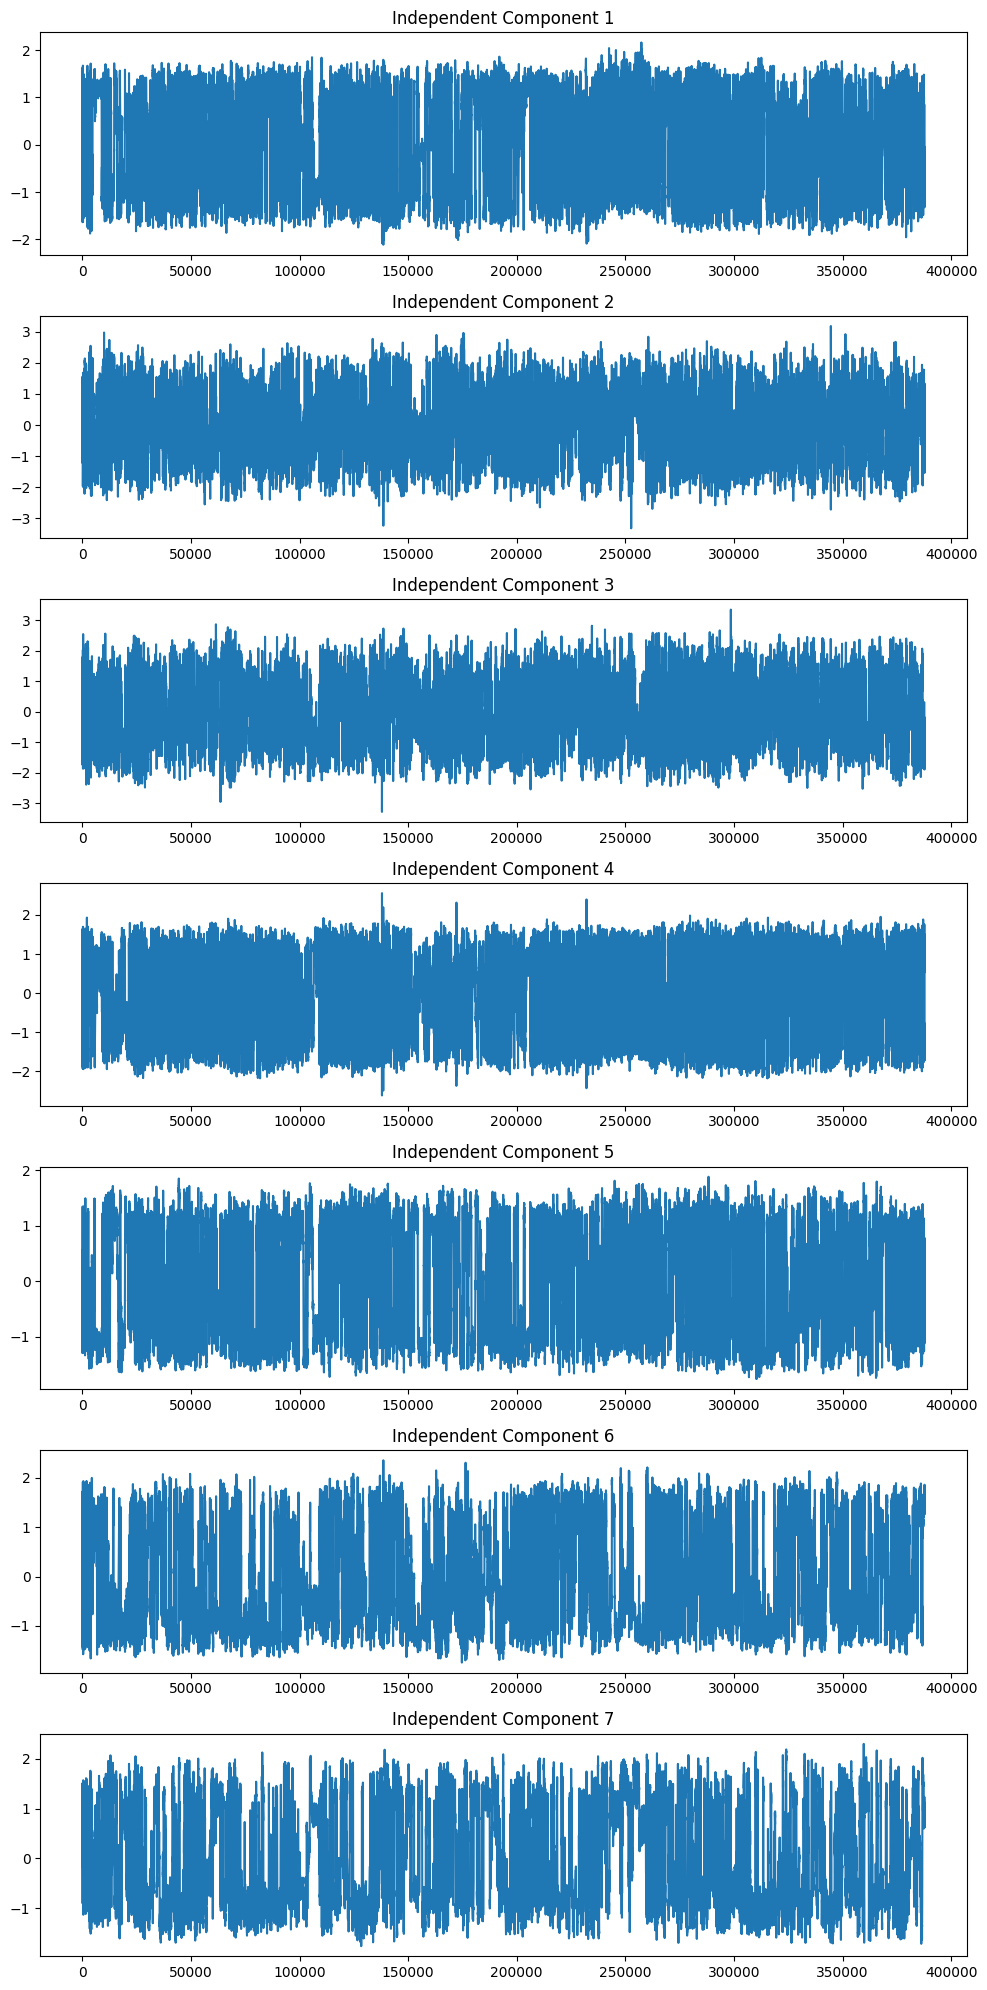

In [ ]:
# Assuming that ics and labels are numpy arrays
assert isinstance(ics, np.ndarray)
assert isinstance(labels, np.ndarray)

# Create a figure and axes
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(10, 20))

# For each independent component
for i in range(7):
    ax = axes[i]
    ax.plot(ics[:, i])
    ax.set_title(f'Independent Component {i+1}')

plt.tight_layout()
plt.show()

! Warning Code below takes super long time to proceed -> ~40 min wasnt enough

In [ ]:
# from sklearn import svm
# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.model_selection import train_test_split

# # First, we need to prepare the behavior labels. Let's assume that all_annotations is a 1D array with the same length as ics.
# all_annotations = all_annotations[:len(ics)]  # Just in case all_annotations is longer

# # Next, split the data and the labels into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(ics, all_annotations, test_size=0.2, random_state=42)

# # Train the SVM classifier
# clf = svm.SVC(kernel='linear', decision_function_shape='ovo')  # Linear Kernel
# clf.fit(X_train, y_train)

# # Predict the response for test dataset
# y_pred = clf.predict(X_test)

# # Evaluate the model
# print(classification_report(y_test, y_pred))

# # You can also display the confusion matrix to see how well the model did on each class
# print(confusion_matrix(y_test, y_pred))


In [ ]:
# This is the version that proceed only 10% of data for testing
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Assuming that all_annotations is a 1D array with the same length as ics.
# In case all_annotations is longer, we trim it to match ics length
all_annotations = all_annotations[:len(ics)]

# If you want to use a smaller portion of your data you can do something like:
data_fraction = 0.3  # Use 10% of the data
num_samples = int(len(ics) * data_fraction)

# Now we only use the first num_samples samples from ics and all_annotations
small_ics = ics[:num_samples]
small_annotations = all_annotations[:num_samples]

# Split the data and the labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(small_ics, small_annotations, test_size=0.2, random_state=42)

# Train the SVM classifier
clf = svm.SVC(kernel='linear', decision_function_shape='ovo')  # Linear Kernel
clf.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# You can also display the confusion matrix to see how well the model did on each class
print(confusion_matrix(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

       attack       0.00      0.00      0.00      1052
investigation       0.00      0.00      0.00      5229
        mount       0.00      0.00      0.00      1960
        other       0.65      1.00      0.78     15036

     accuracy                           0.65     23277
    macro avg       0.16      0.25      0.20     23277
 weighted avg       0.42      0.65      0.51     23277

[[    0     0     0  1052]
 [    0     0     0  5229]
 [    0     0     0  1960]
 [    0     0     0 15036]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
!pip install seaborn


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report:
               precision    recall  f1-score   support

       attack       0.00      0.00      0.00      1052
investigation       0.00      0.00      0.00      5229
        mount       0.00      0.00      0.00      1960
        other       0.65      1.00      0.78     15036

     accuracy                           0.65     23277
    macro avg       0.16      0.25      0.20     23277
 weighted avg       0.42      0.65      0.51     23277



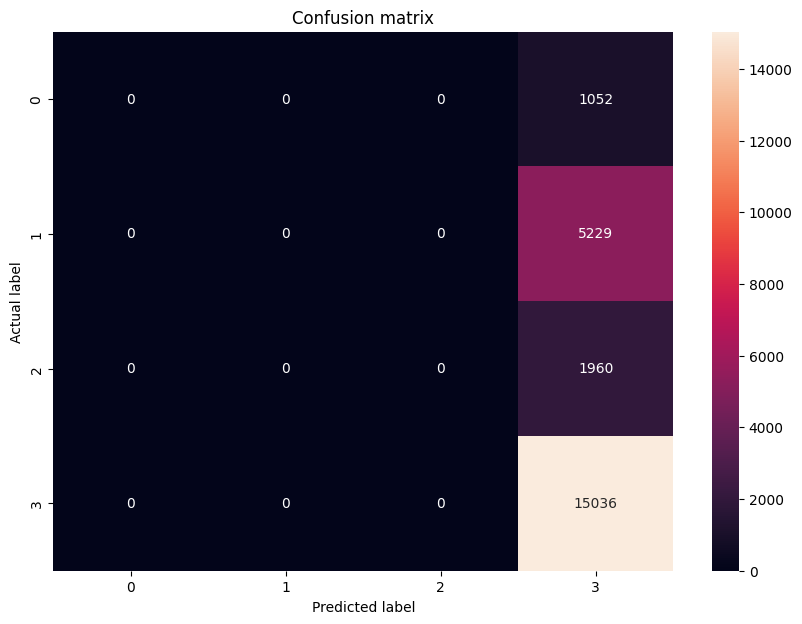

In [ ]:
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Generate the classification report
cr = classification_report(y_test, y_pred)

print("Classification report:")
print(cr)

# Generate a heatmap from the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


# Next section